## Analyzing the Impact of External Factors on Retail Store Sales: A Regression Analysis

### Introduction
In the dynamic landscape of retail, understanding the myriad factors that drive store sales has become paramount for businesses aiming to achieve sustained growth and profitability. Sales performance could be influenced not only by internal strategies and product offerings but also by a complex interplay of external factors. These external variables, ranging from economic indicators and climatic conditions to holidays and marketing endeavors, can exert substantial influence on consumer behavior and purchasing patterns. As the retail industry continues to evolve, there is a pressing need to uncover the relationships between these external factors and store sales with a higher degree of precision. This study aims to contribute to this understanding through a rigorous regression analysis, offering insights that can empower retail companies to make informed decisions and optimize their strategies for enhanced sales outcomes.

### Problem Statement
The central problem under investigation in this study is to ascertain the extent to which external factors impact the sales performance of retail stores. While it is widely acknowledged that both internal and external factors contribute to sales fluctuations, there remains a gap in comprehending the specific nature and magnitude of these external influences. Existing research has shown that factors such as economic indicators, weather variations, promotional campaigns, and cultural events can impact consumer spending behavior. However, there is a lack of comprehensive empirical analysis that quantifies the relationships between these external variables and store sales within a unified framework.

### Aim of Project
The aim of this project is to investigate how certain external factors such as oil prices, holiday-events, and natural ocurrances impact the sales of products of Favorita Retail Stores in Ecuador.

## Set Up The Project Environment

Install the necessary Python libraries: pandas, numpy, scikit-learn, matplotlib, and any specific time series libraries like statsmodels.

In [1]:
# Load the libraries/modules

# For data manipulation and cleaning
import pandas as pd # a tool for data analysis and manipulation.
import numpy as np # a tool for numerical computations.
from datetime import datetime

# For data visualizations
import matplotlib.pyplot as plt # a tool for ploting graphs/charts.
import plotly.express as px
import seaborn as sns # a tool built on matplotlib for plotting graphs/charts.

# For imputing missing values
from sklearn.impute import SimpleImputer

# For encoding numerical, categorical data, creating a pipeline and converting back to Dataframe
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder,MinMaxScaler
from sklearn.compose import make_column_selector
from scipy.sparse import csr_matrix

# For Statistical analysis and testing
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.stats.diagnostic import acorr_ljungbox

# Perform Stationarity Test
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.stattools import adfuller

# For model selections and modeling
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_log_error, mean_squared_error
import phik
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb
from sklearn.tree import DecisionTreeRegressor
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.statespace.sarimax import SARIMAX


# Other supporting libraries
import random
import pyodbc #  helps in making access to SQL Server database simple.
from dotenv import dotenv_values # helps to get login credential to the database.

import warnings # Hiding not too major the warnings.
warnings.filterwarnings('ignore')


In [2]:
# Create an environment to store sentitive information
environment_variables = dotenv_values('.env')

database_name = environment_variables.get('DATABASE')
server_name   = environment_variables.get('SERVER')
user_name     = environment_variables.get('UID')
password      = environment_variables.get('PWD')

connection_string = f'DRIVER={{SQL Server}};DATABASE={database_name};SERVER={server_name};UID={user_name};PWD={password};'

In [3]:
# Connecting to the Database
connection = pyodbc.connect(connection_string)

In [4]:
# Loading the data in pandas to work on.

# Queries to retrieve tables from the Database dapDB
query1 ='SELECT * FROM dbo.oil'
query2 ='SELECT * FROM dbo.holidays_events'
query3 ='SELECT * FROM dbo.stores'

# Redefine datatypes
dtypes = {'id':'int64', 'store_nbr':'int8', 'onpromotion': str}

#Loading the data from the Database dapDB
oil_data = pd.read_sql(query1, connection, parse_dates=['date'])
holi_eve_data = pd.read_sql(query2, connection, parse_dates=['date'], dtype={'transferred': str})
stores_data = pd.read_sql(query3, connection)

#Loading the two data stored in Onedrive
sample_sub_data = pd.read_csv('C:/Users/USER8/Desktop/Azubi Africa/Career Accelerator/LP3/Onedrive files/sample_submission.csv')
test_data = pd.read_csv('C:/Users/USER8/Desktop/Azubi Africa/Career Accelerator/LP3/Onedrive files/test.csv', parse_dates=['date'], dtype=dtypes)

# Loading the two data stored in GitHub
train_data = pd.read_csv('C:/Users/USER8/Desktop/Azubi Africa/Career Accelerator/LP3/GitHub files/train.csv', parse_dates=['date'], dtype=dtypes)
transc_data = pd.read_csv('C:/Users/USER8/Desktop/Azubi Africa/Career Accelerator/LP3/GitHub files/transactions.csv', parse_dates=['date'])

## Data Preprocessing

### Sample submission data

In [5]:
sample_sub_data.head()

,id,sales
0,3000888,0.0
1,3000889,0.0
2,3000890,0.0
3,3000891,0.0
4,3000892,0.0


In [6]:
sample_sub_data.shape

(28512, 2)

In [7]:
sample_sub_data.isna().sum()

id       0
sales    0
dtype: int64

In [8]:
sample_sub_data.duplicated().sum()

0

In [9]:
sample_sub_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28512 entries, 0 to 28511
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   id      28512 non-null  int64  
 1   sales   28512 non-null  float64
dtypes: float64(1), int64(1)
memory usage: 445.6 KB


### Oil data

In [10]:
oil_data.head()

,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.139999
2,2013-01-03,92.970001
3,2013-01-04,93.120003
4,2013-01-07,93.199997


In [11]:
oil_data.shape

(1218, 2)

In [12]:
oil_data.isna().sum()

date           0
dcoilwtico    43
dtype: int64

In [13]:
oil_data.duplicated().sum()

0

In [14]:
oil_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1218 entries, 0 to 1217
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   date        1218 non-null   datetime64[ns]
 1   dcoilwtico  1175 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 19.2 KB


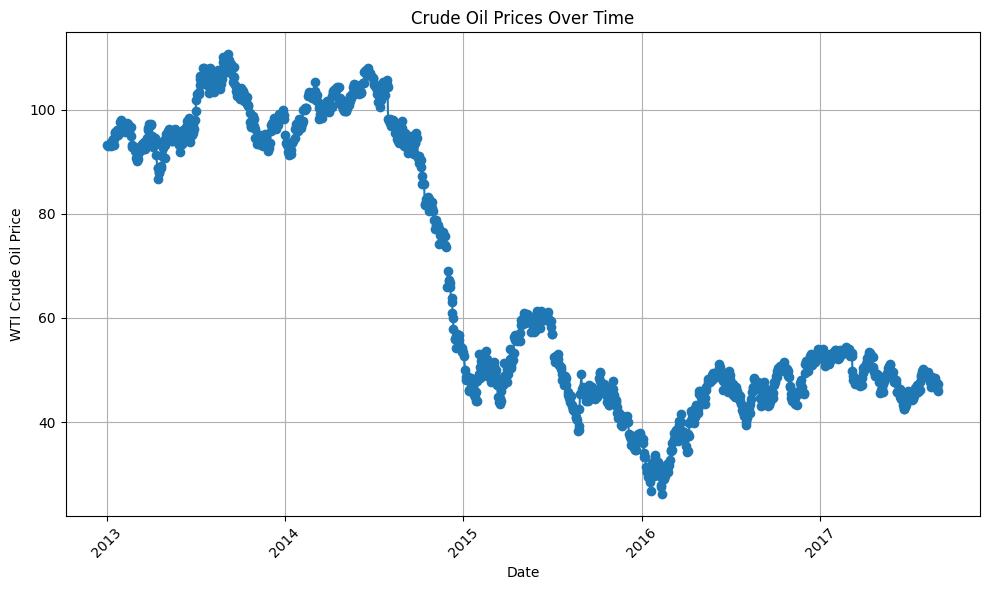

In [15]:
# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(oil_data['date'], oil_data['dcoilwtico'], marker='o', linestyle='-')
plt.title('Crude Oil Prices Over Time')
plt.xlabel('Date')
plt.ylabel('WTI Crude Oil Price')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

# Show the plot
plt.show()

### Store dataset

In [16]:
stores_data.head()

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


In [17]:
stores_data['city'].unique()

array(['Quito', 'Santo Domingo', 'Cayambe', 'Latacunga', 'Riobamba',
       'Ibarra', 'Guaranda', 'Puyo', 'Ambato', 'Guayaquil', 'Salinas',
       'Daule', 'Babahoyo', 'Quevedo', 'Playas', 'Libertad', 'Cuenca',
       'Loja', 'Machala', 'Esmeraldas', 'Manta', 'El Carmen'],
      dtype=object)

In [18]:
stores_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54 entries, 0 to 53
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   store_nbr  54 non-null     int64 
 1   city       54 non-null     object
 2   state      54 non-null     object
 3   type       54 non-null     object
 4   cluster    54 non-null     int64 
dtypes: int64(2), object(3)
memory usage: 2.2+ KB


In [19]:
stores_data.isna().sum()

store_nbr    0
city         0
state        0
type         0
cluster      0
dtype: int64

In [20]:
stores_data.duplicated().sum()

0

In [21]:
stores_data['type'].unique()

array(['D', 'B', 'C', 'E', 'A'], dtype=object)

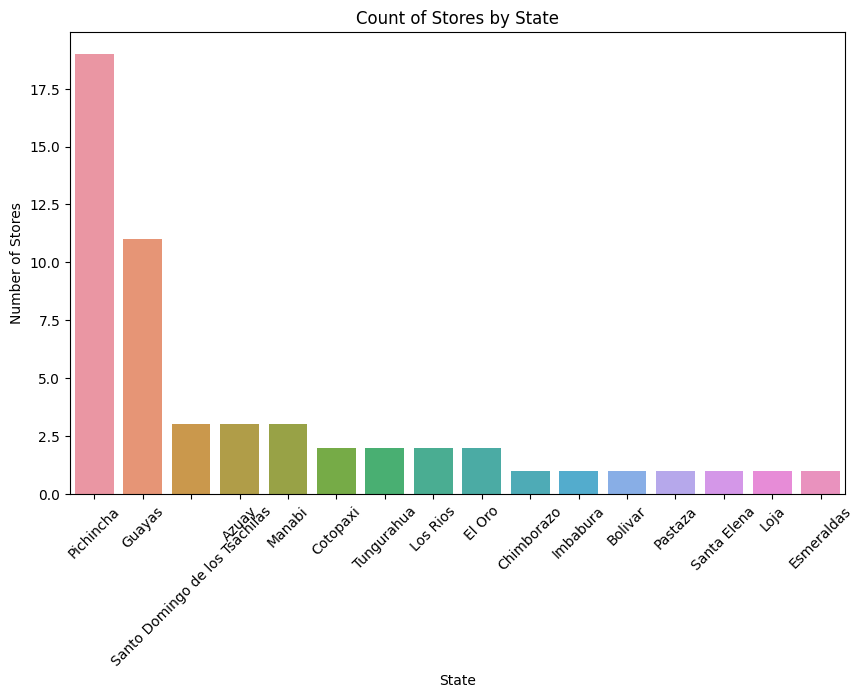

In [22]:
# Count of stores by state
stores_by_state = stores_data['state'].value_counts().reset_index()

# Plot the graph
plt.figure(figsize=(10, 6))
sns.barplot(data=stores_by_state, x='state', y='count')
plt.title('Count of Stores by State')
plt.xlabel('State')
plt.ylabel('Number of Stores')
plt.xticks(rotation=45)

# Show
plt.show()

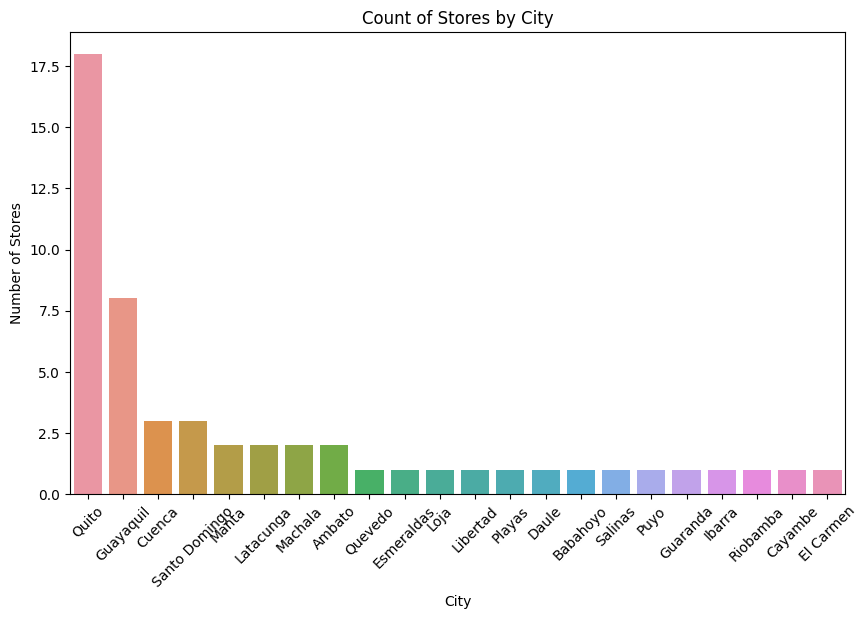

In [23]:
# Count of stores by city
stores_by_city = stores_data['city'].value_counts().reset_index()

# Plot the graph
plt.figure(figsize=(10, 6))
sns.barplot(data=stores_by_city, x='city', y='count')
plt.title('Count of Stores by City')
plt.xlabel('City')
plt.ylabel('Number of Stores')
plt.xticks(rotation=45)

# Show
plt.show()

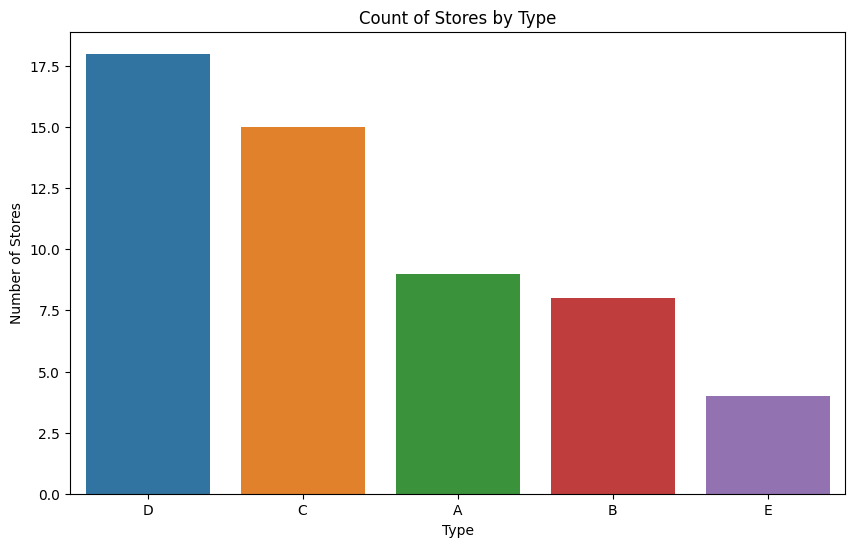

In [24]:
# Count of stores by type
stores_by_type = stores_data['type'].value_counts().reset_index()

# Plot the graph
plt.figure(figsize=(10, 6))
sns.barplot(data=stores_by_type, x='type', y='count')
plt.title('Count of Stores by Type')
plt.xlabel('Type')
plt.ylabel('Number of Stores')

# Show
plt.show()

### Holiday/Events dataset

In [25]:
holi_eve_data.head(5)

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


In [26]:
holi_eve_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 350 entries, 0 to 349
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         350 non-null    datetime64[ns]
 1   type         350 non-null    object        
 2   locale       350 non-null    object        
 3   locale_name  350 non-null    object        
 4   description  350 non-null    object        
 5   transferred  350 non-null    object        
dtypes: datetime64[ns](1), object(5)
memory usage: 16.5+ KB


In [27]:
holi_eve_data.isna().sum()

date           0
type           0
locale         0
locale_name    0
description    0
transferred    0
dtype: int64

In [28]:
holi_eve_data.duplicated().sum()

0

In [29]:
holi_eve_data.shape

(350, 6)

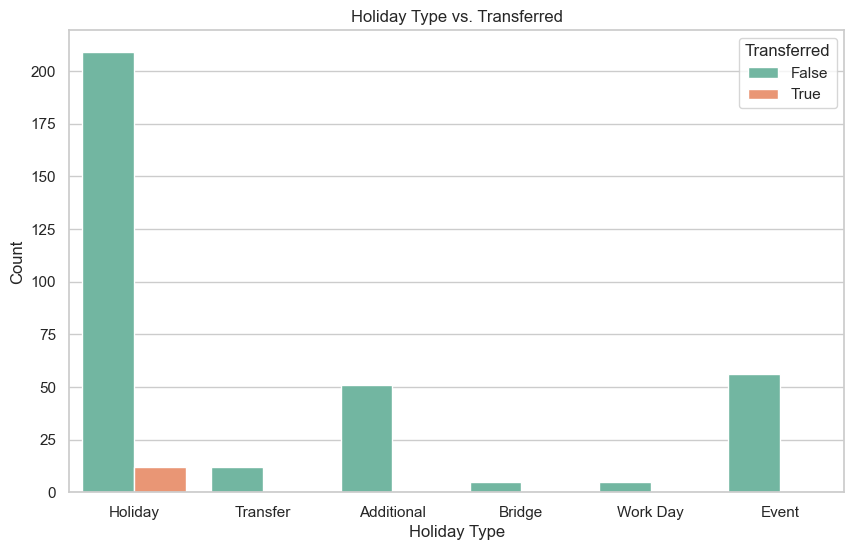

In [30]:
# Create a Seaborn style plot
sns.set(style='whitegrid')
plt.figure(figsize=(10, 6))

# Plot the data using Seaborn
sns.countplot(data=holi_eve_data, x='type', hue='transferred', palette='Set2')
plt.title('Holiday Type vs. Transferred')
plt.xlabel('Holiday Type')
plt.ylabel('Count')
plt.legend(title='Transferred')

# Show the plot
plt.show()

### Transaction Dataset

In [31]:
transc_data.head()

,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358
3,2013-01-02,3,3487
4,2013-01-02,4,1922


In [32]:
transc_data.shape

(83488, 3)

In [33]:
transc_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83488 entries, 0 to 83487
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   date          83488 non-null  datetime64[ns]
 1   store_nbr     83488 non-null  int64         
 2   transactions  83488 non-null  int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 1.9 MB


In [34]:
transc_data.isna().sum()

date            0
store_nbr       0
transactions    0
dtype: int64

In [35]:
transc_data.duplicated().sum()

0

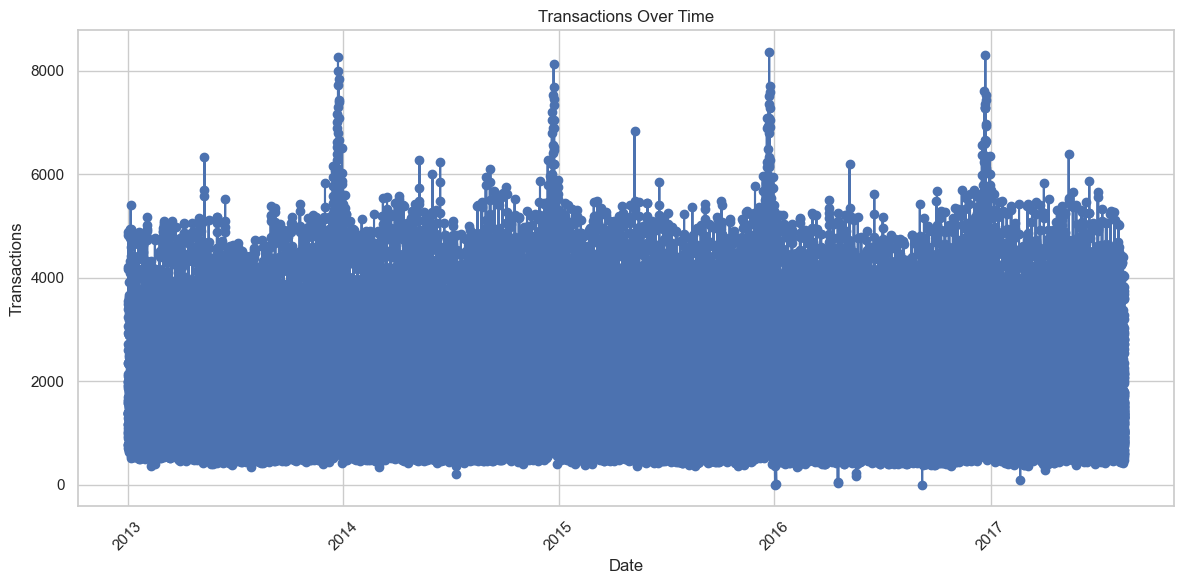

In [36]:
# Create the plot
plt.figure(figsize=(12, 6))
plt.plot(transc_data['date'], transc_data['transactions'], marker='o', linestyle='-')
plt.title('Transactions Over Time')
plt.xlabel('Date')
plt.ylabel('Transactions')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

# Show the plot
plt.show()

In [37]:
# Find the maximum and minimum dates
max_date = transc_data['date'].max()
min_date = transc_data['date'].min()

print("Maximum Date:", max_date)
print("Minimum Date:", min_date)

Maximum Date: 2017-08-15 00:00:00
Minimum Date: 2013-01-01 00:00:00


### Train dataset

In [38]:
# take a look at the first 5 rows of the data
train_data.head()

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0


In [39]:
# view the dimension of the data
train_data.shape

(3000888, 6)

In [40]:
# checking the nan values in each column
train_data.isna().sum()

id             0
date           0
store_nbr      0
family         0
sales          0
onpromotion    0
dtype: int64

In [41]:
# checking for duplicates in the data 
train_data.duplicated().sum()

0

In [42]:
# view the data information
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 6 columns):
 #   Column       Dtype         
---  ------       -----         
 0   id           int64         
 1   date         datetime64[ns]
 2   store_nbr    int8          
 3   family       object        
 4   sales        float64       
 5   onpromotion  object        
dtypes: datetime64[ns](1), float64(1), int64(1), int8(1), object(2)
memory usage: 117.3+ MB


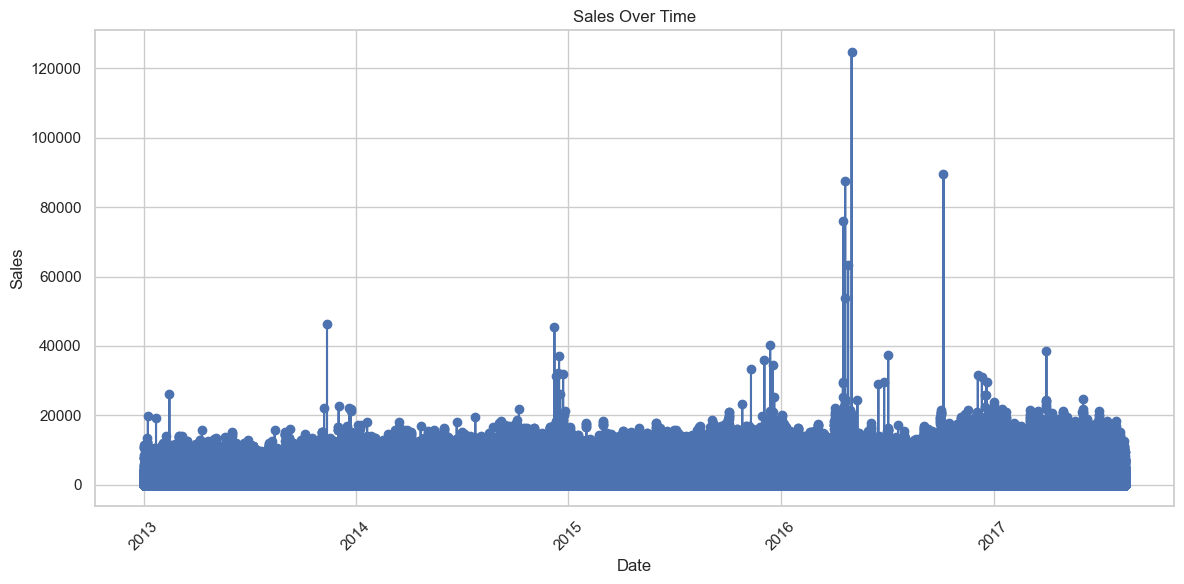

In [43]:
# Create the plot
plt.figure(figsize=(12, 6))
plt.plot(train_data['date'], train_data['sales'], marker='o', linestyle='-')
plt.title('Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

# Show the plot
plt.show()

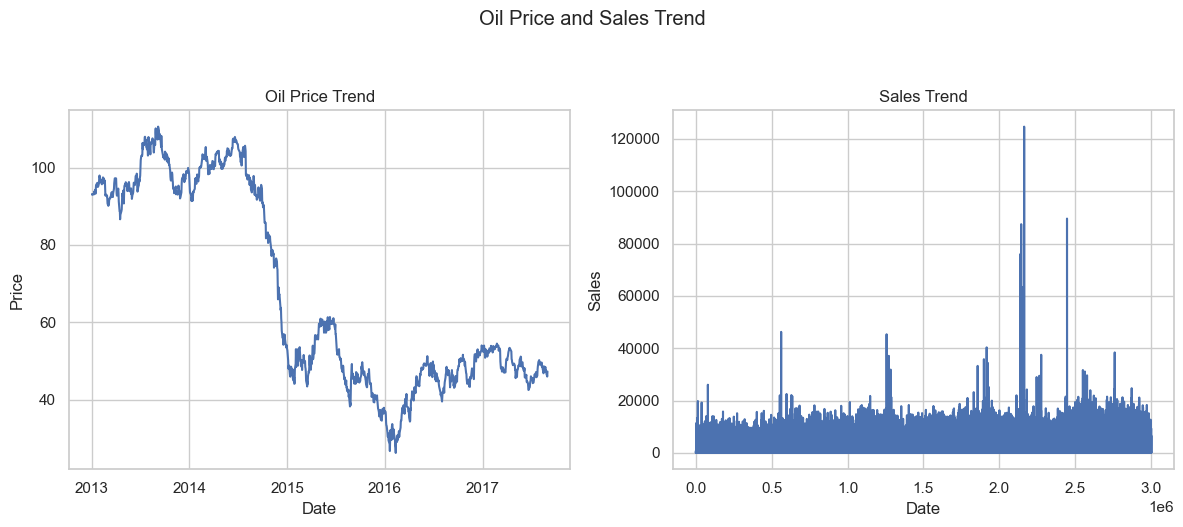

In [44]:
# Comparing the trend of oil price and the trend of sales

# Create subplots with 1 row and 2 columns
plt.figure(figsize=(12, 5)) 

# Create the first subplot in a 1x2 grid
plt.subplot(1, 2, 1)

# Create a line plot for oil price
sns.lineplot(data=oil_data, x='date', y='dcoilwtico')  
plt.title('Oil Price Trend') 
plt.xlabel('Date') 
plt.ylabel('Price') 

 # Create the second subplot in a 1x2 grid
plt.subplot(1, 2, 2) 

# Create a line plot for sales trend
sns.lineplot(data=train_data, x=train_data.index, y='sales')  
plt.title('Sales Trend')  
plt.xlabel('Date') 
plt.ylabel('Sales')

# Set the common title above the subplots
plt.suptitle('Oil Price and Sales Trend', y=1.05)

# Adjust subplot layout for better spacing
plt.tight_layout() 

# Display the plot
plt.show()

## DATA ASSESSMENT

Following data gathering from various sources, a comprehensive assessment was conducted to evaluate quality issues both visually and programmatically.

### DATA QUALITY ISSUES


During the preliminary dataset exploration, several data quality issues were identified, and they are summarized below:

   
1. Completeness:
   - Missing data points in the dcoilwtico column of the oil dataset.


### Hypothesis 
Null Hypothesis (H0):
External factors have no significant impact on retail store sales.

Alternative Hypothesis (H1):
External factors have a significant impact on retail store sales.

### RATIONALE

The rationale for testing these hypotheses is to determine whether there is empirical evidence to support the idea that promotions have a meaningful impact on sales in supermarkets.

By testing these hypotheses and examining the correlation between promotions and sales, businesses can gain valuable insights into the dynamics of supermarket sales and make evidence-based decisions regarding their promotional strategies.

### DATA CLEANING

In [45]:
# Rename the column 'dcoilwtico' to 'oil price'
oil_data.rename(columns={'dcoilwtico': 'oil price'}, inplace=True)

# Rename the column 'type' to 'Holiday Type'
holi_eve_data.rename(columns={'type': 'Holiday Type'}, inplace=True)

# Rename the column 'type' to 'Store Type'
stores_data.rename(columns={'type': 'Store Type'}, inplace=True)

# Rename the 'family' column
train_data.rename(columns={'family': 'Product'}, inplace=True)

In [46]:
# Fill NaN values in the 'dcoilwtico' column using forward-fill (pad)
oil_data['oil price'].fillna(method='ffill', inplace=True)

# Display the DataFrame with filled NaN values
print(oil_data)

           date  oil price
0    2013-01-01        NaN
1    2013-01-02  93.139999
2    2013-01-03  92.970001
3    2013-01-04  93.120003
4    2013-01-07  93.199997
...         ...        ...
1213 2017-08-25  47.650002
1214 2017-08-28  46.400002
1215 2017-08-29  46.459999
1216 2017-08-30  45.959999
1217 2017-08-31  47.259998

[1218 rows x 2 columns]


In [47]:
# Create a date range from the earliest date to the latest date in the dataset
earliest_date = oil_data['date'].min()
latest_date = oil_data['date'].max()
date_range = pd.date_range(start=earliest_date, end=latest_date)

# Find the missing dates by subtracting the existing dates from the full date range
missing_dates = date_range[~date_range.isin(oil_data['date'])]

# Print the missing dates
print("Missing Dates:")
print(missing_dates)

Missing Dates:
DatetimeIndex(['2013-01-05', '2013-01-06', '2013-01-12', '2013-01-13',
               '2013-01-19', '2013-01-20', '2013-01-26', '2013-01-27',
               '2013-02-02', '2013-02-03',
               ...
               '2017-07-29', '2017-07-30', '2017-08-05', '2017-08-06',
               '2017-08-12', '2017-08-13', '2017-08-19', '2017-08-20',
               '2017-08-26', '2017-08-27'],
              dtype='datetime64[ns]', length=486, freq=None)


In [48]:
# Create a date range from the earliest date to the latest date in the dataset
earliest_date = oil_data['date'].min()
latest_date = oil_data['date'].max()
date_range = pd.date_range(start=earliest_date, end=latest_date)

# Find the missing dates by subtracting the existing dates from the full date range
missing_dates = date_range[~date_range.isin(oil_data['date'])]

# Create a DataFrame for missing dates with 'dcoilwtico' column filled using forward-fill
missing_data = pd.DataFrame({'date': missing_dates})
missing_data['oil price'] = missing_data['date'].map(oil_data.set_index('date')['oil price'].fillna(method='ffill'))

# Concatenate the original data with the missing data
oil_data = pd.concat([oil_data, missing_data], ignore_index=True)

# Sort the DataFrame by date
oil_data.sort_values(by='date', inplace=True)

# Display the updated DataFrame
print(oil_data)

           date  oil price
0    2013-01-01        NaN
1    2013-01-02  93.139999
2    2013-01-03  92.970001
3    2013-01-04  93.120003
1218 2013-01-05        NaN
...         ...        ...
1703 2017-08-27        NaN
1214 2017-08-28  46.400002
1215 2017-08-29  46.459999
1216 2017-08-30  45.959999
1217 2017-08-31  47.259998

[1704 rows x 2 columns]


In [49]:
# Sort the DataFrame by date (if it's not already sorted)
oil_data.sort_values(by='date', inplace=True)

# Fill NaN values in the 'dcoilwtico' column using forward-fill (pad)
oil_data['oil price'].fillna(method='ffill', inplace=True)

# Display the DataFrame with filled NaN values
print(oil_data)

           date  oil price
0    2013-01-01        NaN
1    2013-01-02  93.139999
2    2013-01-03  92.970001
3    2013-01-04  93.120003
1218 2013-01-05  93.120003
...         ...        ...
1703 2017-08-27  47.650002
1214 2017-08-28  46.400002
1215 2017-08-29  46.459999
1216 2017-08-30  45.959999
1217 2017-08-31  47.259998

[1704 rows x 2 columns]


In [50]:
# Sort the DataFrame by date (if it's not already sorted)
oil_data.sort_values(by='date', inplace=True)

# Fill NaN values in the 'dcoilwtico' column using forward-fill (pad)
oil_data['oil price'].fillna(method='bfill', inplace=True)

# Display the DataFrame with filled NaN values
print(oil_data)

           date  oil price
0    2013-01-01  93.139999
1    2013-01-02  93.139999
2    2013-01-03  92.970001
3    2013-01-04  93.120003
1218 2013-01-05  93.120003
...         ...        ...
1703 2017-08-27  47.650002
1214 2017-08-28  46.400002
1215 2017-08-29  46.459999
1216 2017-08-30  45.959999
1217 2017-08-31  47.259998

[1704 rows x 2 columns]


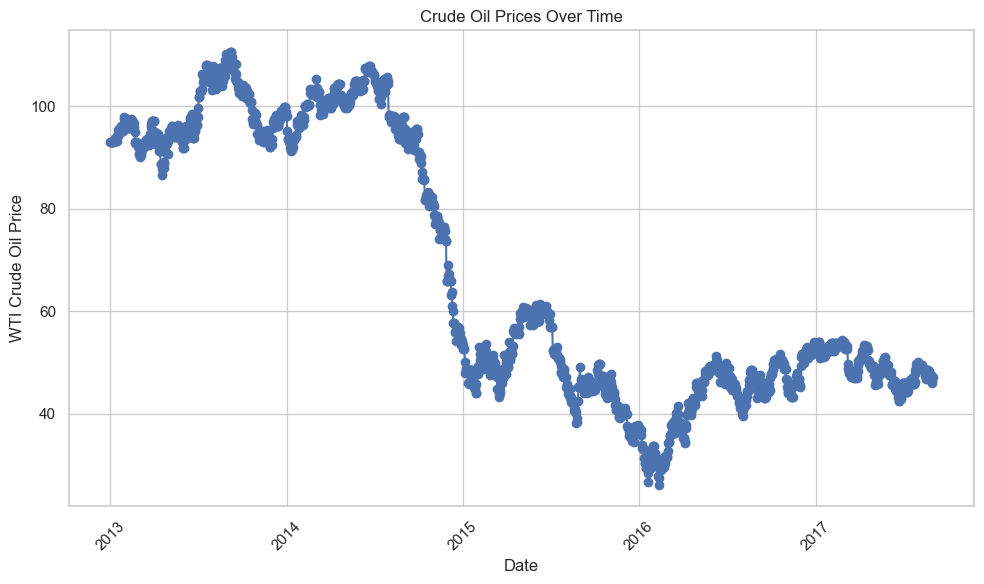

In [51]:
# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(oil_data['date'], oil_data['oil price'], marker='o', linestyle='-')
plt.title('Crude Oil Prices Over Time')
plt.xlabel('Date')
plt.ylabel('WTI Crude Oil Price')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

### Train dataset merging 

In [52]:
# Define a function that check the matching columns across all the dataset 

# Define a Class that assigns the name to the Dataset
class NamedDataFrame(pd.DataFrame):
    def __init__(self, *args, name=None, **kwargs):
        super().__init__(*args, **kwargs)
        self.name = name

# Define a function that output the matching pairs
def find_matching_columns_in_pairs(df:list):
    for df1_idx, (df1, df1_name) in enumerate(df):
        for df2_idx, (df2, df2_name) in enumerate(df):
            if df1_idx < df2_idx:
                common_columns = [i for i in df1.columns if any(i in j for j in df2.columns)]

                print(f"Matching columns between {df1_name} and {df2_name}: {common_columns}")

In [53]:
# Define the dataset names
datasets = [
    (oil_data, 'Oil'),
    (holi_eve_data, 'Holidays Events'),
    (stores_data, 'Stores'),
    (transc_data, 'Transactions'),
    (train_data, 'Train'),
    (test_data, 'Test'),
]

# Apply the function to check the pairs
find_matching_columns_in_pairs(datasets)

Matching columns between Oil and Holidays Events: ['date']
Matching columns between Oil and Stores: []
Matching columns between Oil and Transactions: ['date']
Matching columns between Oil and Train: ['date']
Matching columns between Oil and Test: ['date']
Matching columns between Holidays Events and Stores: []
Matching columns between Holidays Events and Transactions: ['date']
Matching columns between Holidays Events and Train: ['date']
Matching columns between Holidays Events and Test: ['date']
Matching columns between Stores and Transactions: ['store_nbr']
Matching columns between Stores and Train: ['store_nbr']
Matching columns between Stores and Test: ['store_nbr']
Matching columns between Transactions and Train: ['date', 'store_nbr']
Matching columns between Transactions and Test: ['date', 'store_nbr']
Matching columns between Train and Test: ['id', 'date', 'store_nbr', 'onpromotion']


In [54]:
# Define a function that compares the two dates and also check the date range
def date_comparison(date_column1, date_column2):
    """
    Compare two date columns and print counts and date ranges.
    
    Parameters:
    - date_column1: The first date column (as a pandas Series).
    - date_column2: The second date column (as a pandas Series).

    Returns:
    - A dictionary containing the count of common and uncommon dates, as well as date ranges.
    """
    # Convert date columns to sets for faster set operations
    dates1 = set(date_column1)
    dates2 = set(date_column2)

    # Find common dates
    common_dates = dates1.intersection(dates2)
    count_common = len(common_dates)

    # Find uncommon dates
    uncommon_dates = dates1.symmetric_difference(dates2)
    count_uncommon = len(uncommon_dates)

    # Find date range for dates1 dataset
    date_range1 = (min(dates1), max(dates1))

    # Find date range for dates2 dataset
    date_range2 = (min(dates2), max(dates2))

    # Store the counts and date ranges in a dictionary
    results = {
        'Common': count_common,
        'Uncommon': count_uncommon,
        'Date Range 1': date_range1,
        'Date Range 2': date_range2
    }

    return results

In [55]:
# Apply the function to compare for Transaction and Train
compare_result_train= date_comparison(transc_data['date'], train_data['date'])

# print
pd.DataFrame(compare_result_train)

,Common,Uncommon,Date Range 1,Date Range 2
0,1682,2,2013-01-01,2013-01-01
1,1682,2,2017-08-15,2017-08-15


In [56]:
train_mod = train_data.copy()
train_mod = train_data.merge(oil_data, on=['date'])

In [57]:
# Merge holidays events, stores and transactions to the Train
train_mod = train_mod.merge(stores_data, on=['store_nbr'])
train_mod = train_mod.merge(holi_eve_data, on=['date'])
train_mod = train_mod.merge(transc_data, on=['date', 'store_nbr'])

In [58]:
train_mod

,id,date,store_nbr,Product,sales,onpromotion,oil price,city,state,Store Type,cluster,Holiday Type,locale,locale_name,description,transferred,transactions
0,561,2013-01-01,25,AUTOMOTIVE,0.000,0,93.139999,Salinas,Santa Elena,D,1,Holiday,National,Ecuador,Primer dia del ano,False,770
1,562,2013-01-01,25,BABY CARE,0.000,0,93.139999,Salinas,Santa Elena,D,1,Holiday,National,Ecuador,Primer dia del ano,False,770
2,563,2013-01-01,25,BEAUTY,2.000,0,93.139999,Salinas,Santa Elena,D,1,Holiday,National,Ecuador,Primer dia del ano,False,770
3,564,2013-01-01,25,BEVERAGES,810.000,0,93.139999,Salinas,Santa Elena,D,1,Holiday,National,Ecuador,Primer dia del ano,False,770
4,565,2013-01-01,25,BOOKS,0.000,0,93.139999,Salinas,Santa Elena,D,1,Holiday,National,Ecuador,Primer dia del ano,False,770
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
459058,3000883,2017-08-15,9,POULTRY,438.133,0,47.570000,Quito,Pichincha,B,6,Holiday,Local,Riobamba,Fundacion de Riobamba,False,2155
459059,3000884,2017-08-15,9,PREPARED FOODS,154.553,1,47.570000,Quito,Pichincha,B,6,Holiday,Local,Riobamba,Fundacion de Riobamba,False,2155
459060,3000885,2017-08-15,9,PRODUCE,2419.729,148,47.570000,Quito,Pichincha,B,6,Holiday,Local,Riobamba,Fundacion de Riobamba,False,2155
459061,3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000,8,47.570000,Quito,Pichincha,B,6,Holiday,Local,Riobamba,Fundacion de Riobamba,False,2155


In [59]:
train_mod.isnull().sum()

id              0
date            0
store_nbr       0
Product         0
sales           0
onpromotion     0
oil price       0
city            0
state           0
Store Type      0
cluster         0
Holiday Type    0
locale          0
locale_name     0
description     0
transferred     0
transactions    0
dtype: int64

In [60]:
# Get more info
train_mod.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 459063 entries, 0 to 459062
Data columns (total 17 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   id            459063 non-null  int64         
 1   date          459063 non-null  datetime64[ns]
 2   store_nbr     459063 non-null  int8          
 3   Product       459063 non-null  object        
 4   sales         459063 non-null  float64       
 5   onpromotion   459063 non-null  object        
 6   oil price     459063 non-null  float64       
 7   city          459063 non-null  object        
 8   state         459063 non-null  object        
 9   Store Type    459063 non-null  object        
 10  cluster       459063 non-null  int64         
 11  Holiday Type  459063 non-null  object        
 12  locale        459063 non-null  object        
 13  locale_name   459063 non-null  object        
 14  description   459063 non-null  object        
 15  transferred   459

In [61]:
# Generate summary statistics
train_mod.describe()

,id,date,store_nbr,sales,oil price,cluster,transactions
count,4.590630e+05,459063,459063.000000,459063.000000,459063.000000,459063.000000,459063.000000
mean,1.656855e+06,2015-07-21 07:10:49.816691200,26.983538,431.117433,64.567440,8.530587,1798.531234
min,5.610000e+02,2013-01-01 00:00:00,1.000000,0.000000,27.959999,1.000000,33.000000
25%,9.750630e+05,2014-07-03 00:00:00,13.000000,1.000000,44.660000,4.000000,1075.000000
50%,1.842175e+06,2015-11-02 00:00:00,27.000000,20.000000,51.630001,9.000000,1448.000000
75%,2.260392e+06,2016-06-25 00:00:00,40.000000,255.619500,94.559998,13.000000,2201.000000
max,3.000887e+06,2017-08-15 00:00:00,54.000000,124717.000000,107.949997,17.000000,8359.000000
std,8.119452e+05,NaN,15.594634,1305.045225,25.097389,4.715494,1097.538319


In [62]:
# Get the unique years contained in the dataset
train_mod['date'].dt.year.unique()

array([2013, 2014, 2015, 2016, 2017])

From the output above, The dataset contains information spanning across five consecutive years, namely 2013, 2014, 2015, 2016, and 2017. 

In [63]:
# Decompose the date column into Year, Year-Month, Month and Day to facilitate deep analysis
# year
train_mod['year'] = train_mod.date.dt.year

# year-month
train_mod['year-month'] = train_mod['date'].apply(lambda x : x.strftime('%Y-%m'))

# month
train_mod['month'] = train_mod.date.dt.month

# day
train_mod['day'] = train_mod.date.dt.day

In [64]:
# Confirm changes
train_mod.head()

,id,date,store_nbr,Product,sales,onpromotion,oil price,city,state,Store Type,...,Holiday Type,locale,locale_name,description,transferred,transactions,year,year-month,month,day
0,561,2013-01-01,25,AUTOMOTIVE,0.0,0,93.139999,Salinas,Santa Elena,D,...,Holiday,National,Ecuador,Primer dia del ano,False,770,2013,2013-01,1,1
1,562,2013-01-01,25,BABY CARE,0.0,0,93.139999,Salinas,Santa Elena,D,...,Holiday,National,Ecuador,Primer dia del ano,False,770,2013,2013-01,1,1
2,563,2013-01-01,25,BEAUTY,2.0,0,93.139999,Salinas,Santa Elena,D,...,Holiday,National,Ecuador,Primer dia del ano,False,770,2013,2013-01,1,1
3,564,2013-01-01,25,BEVERAGES,810.0,0,93.139999,Salinas,Santa Elena,D,...,Holiday,National,Ecuador,Primer dia del ano,False,770,2013,2013-01,1,1
4,565,2013-01-01,25,BOOKS,0.0,0,93.139999,Salinas,Santa Elena,D,...,Holiday,National,Ecuador,Primer dia del ano,False,770,2013,2013-01,1,1


In [65]:
# Check distinct month
sorted(train_mod['month'].unique())

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

In [66]:
# Convert onpromotion to int
train_mod['onpromotion'] = train_mod['onpromotion'].astype('int')

### Analysis

In [67]:
train_mod

,id,date,store_nbr,Product,sales,onpromotion,oil price,city,state,Store Type,...,Holiday Type,locale,locale_name,description,transferred,transactions,year,year-month,month,day
0,561,2013-01-01,25,AUTOMOTIVE,0.000,0,93.139999,Salinas,Santa Elena,D,...,Holiday,National,Ecuador,Primer dia del ano,False,770,2013,2013-01,1,1
1,562,2013-01-01,25,BABY CARE,0.000,0,93.139999,Salinas,Santa Elena,D,...,Holiday,National,Ecuador,Primer dia del ano,False,770,2013,2013-01,1,1
2,563,2013-01-01,25,BEAUTY,2.000,0,93.139999,Salinas,Santa Elena,D,...,Holiday,National,Ecuador,Primer dia del ano,False,770,2013,2013-01,1,1
3,564,2013-01-01,25,BEVERAGES,810.000,0,93.139999,Salinas,Santa Elena,D,...,Holiday,National,Ecuador,Primer dia del ano,False,770,2013,2013-01,1,1
4,565,2013-01-01,25,BOOKS,0.000,0,93.139999,Salinas,Santa Elena,D,...,Holiday,National,Ecuador,Primer dia del ano,False,770,2013,2013-01,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
459058,3000883,2017-08-15,9,POULTRY,438.133,0,47.570000,Quito,Pichincha,B,...,Holiday,Local,Riobamba,Fundacion de Riobamba,False,2155,2017,2017-08,8,15
459059,3000884,2017-08-15,9,PREPARED FOODS,154.553,1,47.570000,Quito,Pichincha,B,...,Holiday,Local,Riobamba,Fundacion de Riobamba,False,2155,2017,2017-08,8,15
459060,3000885,2017-08-15,9,PRODUCE,2419.729,148,47.570000,Quito,Pichincha,B,...,Holiday,Local,Riobamba,Fundacion de Riobamba,False,2155,2017,2017-08,8,15
459061,3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000,8,47.570000,Quito,Pichincha,B,...,Holiday,Local,Riobamba,Fundacion de Riobamba,False,2155,2017,2017-08,8,15


## Time Series Decomposition 

Decompose the time series into its components: trend, seasonality, and residual.
This step helps you understand the underlying patterns in the data and can guide your modeling choices.

In [68]:
# Define a function that is responsible for ploting the time series component individually
def decompose(df, column_name):
    """
    Decompose a time series into trend, seasonality, and residual components using both multiplicative and additive models.

    Parameters:
        df (DataFrame): The input DataFrame containing time series data.
        column_name (str): The column name for which trend, seasonality, and residual are to be captured.

    Returns:
        result_mul (seasonal_decompose): Result of the multiplicative decomposition.
        result_add (seasonal_decompose): Result of the additive decomposition.
    """
    # Perform multiplicative decomposition
    result_mul = seasonal_decompose(df.groupby(df['date'])[column_name].sum(), model='multiplicative', extrapolate_trend='freq', period=12)
    
    # Perform additive decomposition
    result_add = seasonal_decompose(df.groupby(df['date'])[column_name].sum(), model='additive', extrapolate_trend='freq', period=12)

    # Set plot size and create subplots
    plt.rcParams.update({'figure.figsize': (18, 10)})
    fig, ax = plt.subplots(4, 2)  # 4 rows, 2 columns for two sets of plots

    # Plot multiplicative decomposition
    result_mul.observed.plot(ax=ax[0, 0])
    result_mul.trend.plot(ax=ax[1, 0])
    result_mul.seasonal.plot(ax=ax[2, 0])
    ax[3, 0].scatter(result_mul.resid.index, result_mul.resid, s=20, marker='o', alpha=0.5)  # Scatter plot for residuals

    # Plot additive decomposition
    result_add.observed.plot(ax=ax[0, 1])
    result_add.trend.plot(ax=ax[1, 1])
    result_add.seasonal.plot(ax=ax[2, 1])
    ax[3, 1].scatter(result_add.resid.index, result_add.resid, s=20, marker='o', alpha=0.5)  # Scatter plot for residuals

    # Set suptitles
    ax[0, 0].set_title('Multiplicative Decompose - Observed')
    ax[0, 1].set_title('Additive Decompose - Observed')
    
    ax[1, 0].set_title('Multiplicative Decompose - Trend')
    ax[1, 1].set_title('Additive Decompose - Trend')
    
    ax[2, 0].set_title('Multiplicative Decompose - Seasonal')
    ax[2, 1].set_title('Additive Decompose - Seasonal')
    
    ax[3, 0].set_title('Multiplicative Decompose - Residual')
    ax[3, 1].set_title('Additive Decompose - Residual')

    # Adjust layout
    plt.tight_layout(rect=[0, 0, 1, 0.95])

    # Show the plots
    plt.show()

    return result_mul, result_add

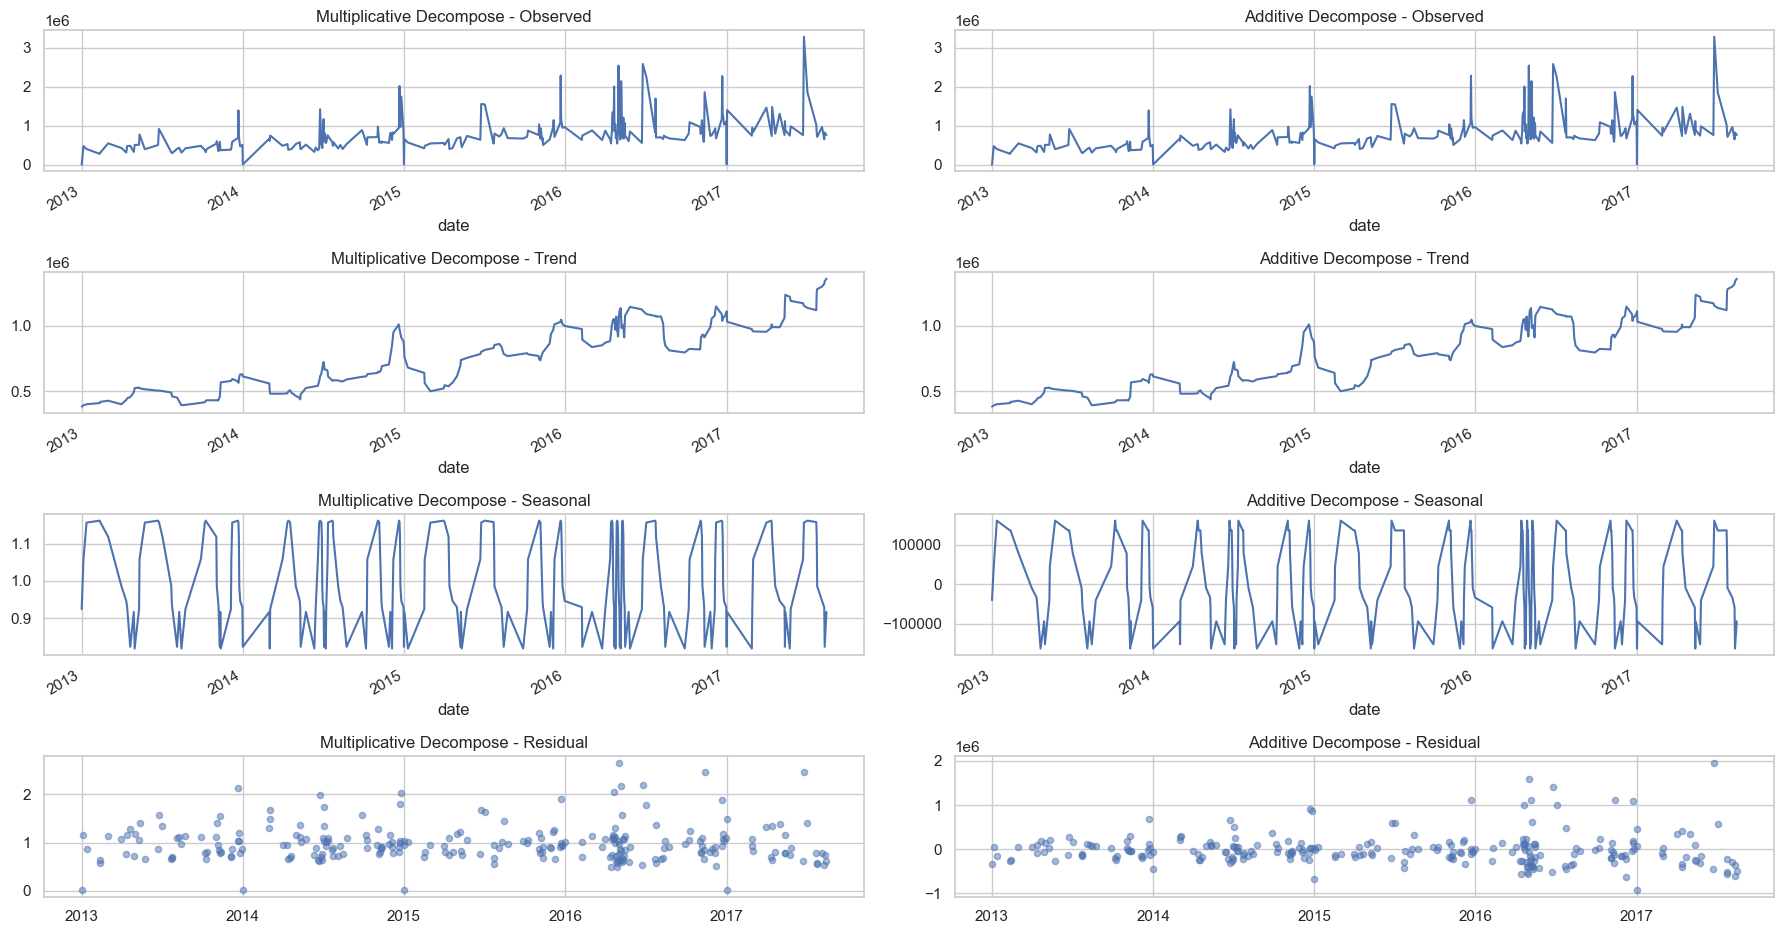

In [69]:
# Generate the various plot by calling the decompose function
result_mul, result_add = decompose(train_mod, 'sales')

In [70]:
# Concatenate the components into a DataFrame
decomposition_df = pd.concat([result_add.seasonal, result_add.trend, result_add.resid, result_add.observed], axis=1)

# Assign column names
decomposition_df.columns = ['seasonal', 'trend', 'residual', 'actual_values']

# View the first 5 rows
decomposition_df.head()

,seasonal,trend,residual,actual_values
date,,,,
2013-01-01,-40866.383697,383823.020595,-340445.017899,2511.618999
2013-01-05,44940.934515,392758.520649,39650.666064,477350.121229
2013-01-12,160514.060978,401694.020704,-158949.869671,403258.212011
2013-02-11,135484.106470,410629.520758,-267486.038302,278627.588926
2013-02-12,135901.753661,419565.020812,-246665.983560,308800.790912


### DATA SAMPLING

Due to limited computational resources, we will sample and work with only 40% of the over 3 million data points in the training set, as our current system cannot handle the entire dataset for the testing of stationarity.

In [71]:
# Define a function to perform the sampling
def data_sample(df, size):
    """
    Randomly samples rows from a DataFrame.

    Parameters:
    - df (pd.DataFrame): The input DataFrame from which to sample.
    - size (float): The proportion of rows to sample (e.g., 0.1 for 10%).

    Returns:
    - pd.DataFrame: A randomly sampled subset of the input DataFrame.
    """
    # Set a seed for reproducibility (optional)
    random.seed(42)

    # Calculate the number of rows to sample based on the specified proportion
    sample_size = int(size * len(df))

    # Randomly select rows to create a sample
    sampled_data = df.sample(n=sample_size)

    return sampled_data

In [72]:

# Apply the function to sample the 40%
sampled_train = data_sample(train_mod, 0.3)

In [73]:
# Confirm changes
sampled_train.shape

(137718, 21)

In [74]:
sampled_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 137718 entries, 726 to 85276
Data columns (total 21 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   id            137718 non-null  int64         
 1   date          137718 non-null  datetime64[ns]
 2   store_nbr     137718 non-null  int8          
 3   Product       137718 non-null  object        
 4   sales         137718 non-null  float64       
 5   onpromotion   137718 non-null  int32         
 6   oil price     137718 non-null  float64       
 7   city          137718 non-null  object        
 8   state         137718 non-null  object        
 9   Store Type    137718 non-null  object        
 10  cluster       137718 non-null  int64         
 11  Holiday Type  137718 non-null  object        
 12  locale        137718 non-null  object        
 13  locale_name   137718 non-null  object        
 14  description   137718 non-null  object        
 15  transferred   137718 

In [75]:
# Sales data
time_series = sampled_train['sales']

# Perform the ADF Test with trend and constant
adf_result = adfuller(time_series, regression='ct')

# Perform the KPSS Test with trend and constant
kpss_result = kpss(time_series, regression='ct')

In [76]:
adf_result

(-370.5959252687711,
 0.0,
 0,
 137717,
 {'1%': -3.9588357384813087,
  '5%': -3.410521880346037,
  '10%': -3.127068774940651},
 2369883.6871790388)

In [77]:
# Print result of KPSS
kpss_result

(0.1721182620255903,
 0.02823478164534141,
 20,
 {'10%': 0.119, '5%': 0.146, '2.5%': 0.176, '1%': 0.216})

In [78]:
result = adfuller(sampled_train['sales'])

# Extract and print the p-value
p_value = result[1]
print(f'p-value: {p_value}')

p-value: 0.0


### TEST FOR AUTOCORRELATION

**1. Autocorrelation Function (ACF):**

The ACF measures the correlation between a time series and its lagged values at various time lags. Each point on the ACF plot represents the correlation between the time series and itself at different lags. Here's how to interpret it:

**2. Partial Autocorrelation Function (PACF):**

The PACF, on the other hand, measures the direct relationship between a time series and its lagged values while removing the influence of shorter lags. Here's how to interpret it:

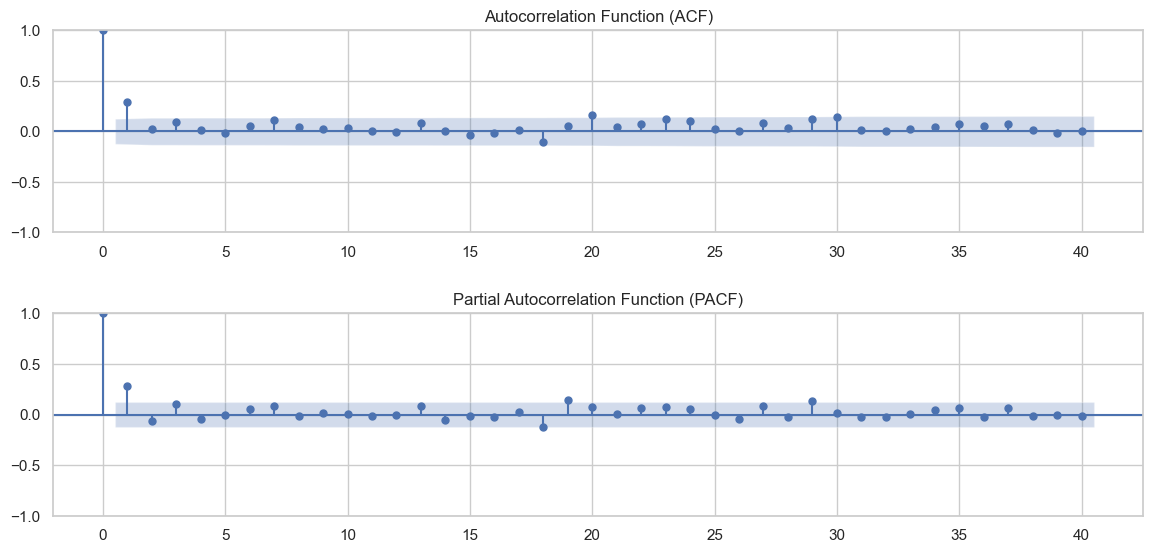

In [79]:
# Get the sales time series data based on the sample
ts = train_data.groupby(train_mod['date'])['sales'].sum()

# Create subplots with 2 rows and 1 column, specifying figsize
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 6))

# Plot the Autocorrelation Function (ACF) on the first subplot (ax1)
sm.graphics.tsa.plot_acf(ts, lags=40, ax=ax1)
ax1.set_title("Autocorrelation Function (ACF)")  # Add a title to the first subplot

# Plot the Partial Autocorrelation Function (PACF) on the second subplot (ax2)
sm.graphics.tsa.plot_pacf(ts, lags=40, ax=ax2)
ax2.set_title("Partial Autocorrelation Function (PACF)")  # Add a title to the second subplot

# Add padding between the two subplots for better visualization
plt.tight_layout(pad=2.0)

# Display the plots
plt.show()

### Check for Correlation
The correlation matrix provides valuable insights into which columns to include in our sales prediction model. This allows to identifying the most relevant features that can be included in building an accurate forecasting model for future sales.

In [80]:
# Check for linear associations between the variables
correlation_matrix = train_mod.phik_matrix()

interval columns not set, guessing: ['id', 'store_nbr', 'sales', 'onpromotion', 'oil price', 'cluster', 'transactions', 'year', 'month', 'day']


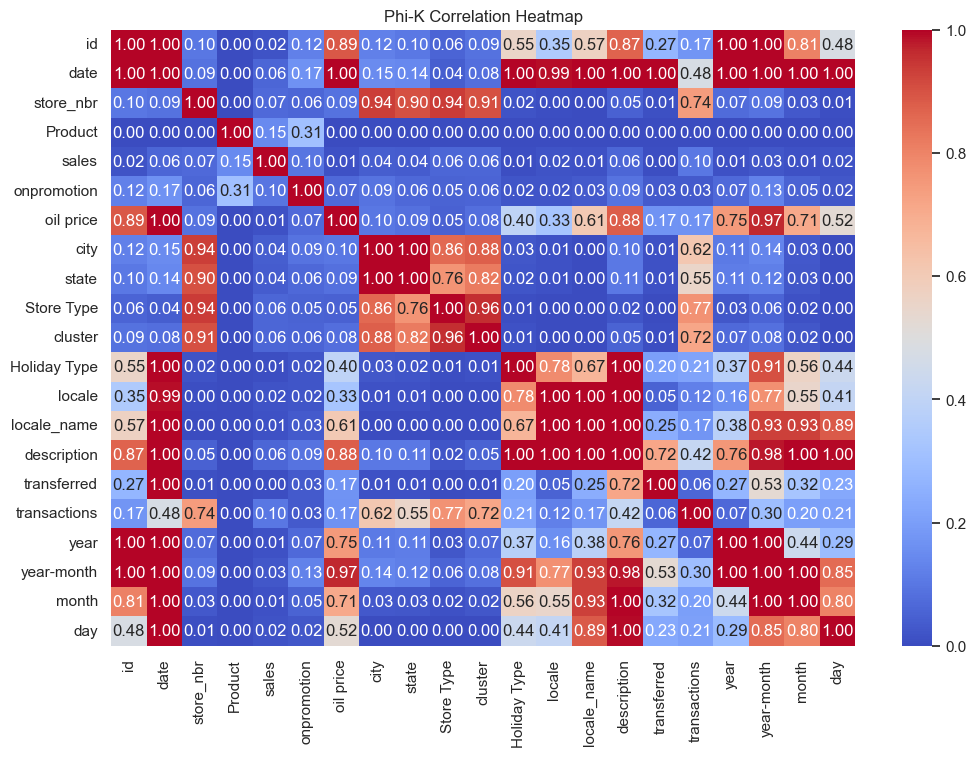

In [81]:
# Plot the correlation matrix
plt.figure(figsize=(12, 8)) # Set the figure size

# Use seaborn to plot the matrix
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm")

# Set the plot title
plt.title("Phi-K Correlation Heatmap")

# Show the plot
plt.show()

### DATA MERGING FOR MODELING AND PREDICTIONS
Given the incomplete nature of the previously used transaction dataset during exploratory data analysis, we will now merge the various datasets once more to ensure a seamless modeling process.

In [82]:
# Merge Stores with Train on store_nbr
train_mac = train_data.merge(stores_data, on='store_nbr', how='left')

In [83]:
# Merge Oil on date
train_mac = train_mac.merge(oil_data, on='date', how='left')

In [84]:
# Merge holidays_events on 'date'
train_mac = train_mac.merge(holi_eve_data, on='date', how='left')

In [85]:
# Convert onpromotion column to numeric
train_mac['onpromotion'] = pd.to_numeric(train_mac['onpromotion'], errors='coerce')

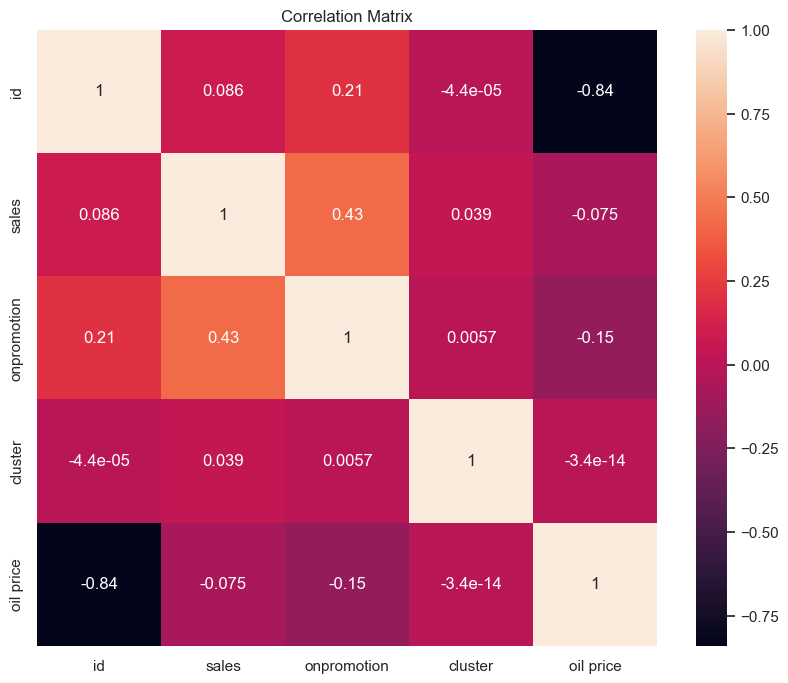

In [86]:
# Calculate the correlation matrix

# Select numeric columns
numeric_df = train_mac.select_dtypes(include=['float64', 'int64'])

# Calculate the correlation matrix
corr_matrix = numeric_df.corr()

# Create a heatmap of the correlation matrix using Seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True)
plt.title('Correlation Matrix')
plt.show()

In [87]:
# Set 'id' column as the index
train_mac.set_index('id', inplace=True)

In [88]:
# Columns to drop
columns_to_drop = [ 'city', 'state', 'Store Type', 'oil price', 'Holiday Type', 'locale', 'locale_name', 'transferred']

# Drop the columns
train_mac = train_mac.drop(columns=columns_to_drop)

In [89]:
# Rearrange columns to make 'sales' the last column
cols = [col for col in train_mac.columns if col != 'sales'] + ['sales']
train_mac = train_mac[cols]

In [90]:
train_mac.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3054348 entries, 0 to 3000887
Data columns (total 7 columns):
 #   Column       Dtype         
---  ------       -----         
 0   date         datetime64[ns]
 1   store_nbr    int8          
 2   Product      object        
 3   onpromotion  int64         
 4   cluster      int64         
 5   description  object        
 6   sales        float64       
dtypes: datetime64[ns](1), float64(1), int64(2), int8(1), object(2)
memory usage: 166.0+ MB


In [91]:
# Aggregating data
aggregated_sales = train_mac.groupby(['date', 'store_nbr', 'Product', 'cluster' ]).agg({ 'sales': 'sum' }).reset_index()

In [92]:
# Define the product category groups
groups = {
    'Grocery and Household Essentials': ['AUTOMOTIVE', 'BABY CARE', 'BEAUTY', 'BEVERAGES', 'BREAD/BAKERY', 'CLEANING', 'DAIRY', 'EGGS', 'GROCERY I', 'GROCERY II', 'HOME AND KITCHEN I', 'HOME AND KITCHEN II', 'HOME APPLIANCES', 'HOME CARE', 'PERSONAL CARE', 'PET SUPPLIES', 'SCHOOL AND OFFICE SUPPLIES'],
    'Apparel and Fashion': ['LADIESWEAR', 'LINGERIE'],
    'Entertainment and Leisure': ['BOOKS', 'CELEBRATION', 'MAGAZINES', 'PLAYERS AND ELECTRONICS'],
    'Hardware and Home Improvement': ['HARDWARE', 'LAWN AND GARDEN'],
    'Food and Beverages': ['DELI', 'FROZEN FOODS', 'LIQUOR,WINE,BEER', 'MEATS', 'PREPARED FOODS', 'PRODUCE', 'SEAFOOD']
}

# Create a new column 'Product_Category_Group' based on the mapping
aggregated_sales['Product_Category'] = aggregated_sales['Product'].apply(lambda x: next((group for group, categories in groups.items() if x in categories), 'Other'))


In [93]:
# Check for mising values
aggregated_sales.isnull().sum()

date                0
store_nbr           0
Product             0
cluster             0
sales               0
Product_Category    0
dtype: int64

### FEATURE ENGINEERING

In [94]:
# Create day of the week feature
aggregated_sales['day_of_week'] = aggregated_sales['date'].dt.dayofweek

# Lag sales by 1 to get the previous day sales value
aggregated_sales['lag_1'] = aggregated_sales['sales'].shift(1)

# Add rolling mean with a 7-day window 
aggregated_sales['rolling_mean'] = aggregated_sales['sales'].rolling(window=7).mean()


In [95]:
# Check for mising values
aggregated_sales.isnull().sum()

date                0
store_nbr           0
Product             0
cluster             0
sales               0
Product_Category    0
day_of_week         0
lag_1               1
rolling_mean        6
dtype: int64

In [96]:
# Drop all Missing values introduced due to lag and rolling mean
aggregated_sales.dropna(inplace=True)

#### DATA PREPROCESSING

In [97]:
aggregated_sales.head()

,date,store_nbr,Product,cluster,sales,Product_Category,day_of_week,lag_1,rolling_mean
6,2013-01-01,1,CELEBRATION,13,0.0,Entertainment and Leisure,1,0.0,0.0
7,2013-01-01,1,CLEANING,13,0.0,Grocery and Household Essentials,1,0.0,0.0
8,2013-01-01,1,DAIRY,13,0.0,Grocery and Household Essentials,1,0.0,0.0
9,2013-01-01,1,DELI,13,0.0,Food and Beverages,1,0.0,0.0
10,2013-01-01,1,EGGS,13,0.0,Grocery and Household Essentials,1,0.0,0.0


In [98]:
# Drop the Family column after one hot encoding
aggregated_sales.drop('Product', axis=1, inplace=True)

In [99]:
aggregated_sales

,date,store_nbr,cluster,sales,Product_Category,day_of_week,lag_1,rolling_mean
6,2013-01-01,1,13,0.000,Entertainment and Leisure,1,0.000,0.000000
7,2013-01-01,1,13,0.000,Grocery and Household Essentials,1,0.000,0.000000
8,2013-01-01,1,13,0.000,Grocery and Household Essentials,1,0.000,0.000000
9,2013-01-01,1,13,0.000,Food and Beverages,1,0.000,0.000000
10,2013-01-01,1,13,0.000,Grocery and Household Essentials,1,0.000,0.000000
...,...,...,...,...,...,...,...,...
3000883,2017-08-15,54,3,59.619,Other,1,2.000,71.494429
3000884,2017-08-15,54,3,94.000,Food and Beverages,1,59.619,54.923000
3000885,2017-08-15,54,3,915.371,Food and Beverages,1,94.000,185.404571
3000886,2017-08-15,54,3,0.000,Grocery and Household Essentials,1,915.371,177.141429


### FEATURE ENCODING & FEATURE SCALING 

In [101]:
numeric_features = ['store_nbr', 'cluster', 'sales', 'day_of_week', 'lag_1', 'rolling_mean']
categorical_features = ['Product_Category']

scaler= MinMaxScaler()
encoder= OneHotEncoder()

# Apply to scale the data
aggregated_sales[numeric_features] = scaler.fit_transform(aggregated_sales[numeric_features])

aggregated_sales[categorical_features] = encoder.fit_transform(aggregated_sales[categorical_features])


In [103]:
# Sort the data by date
aggregated_sales = aggregated_sales.sort_values('date')

In [104]:
aggregated_sales

,date,store_nbr,cluster,sales,Product_Category,day_of_week,lag_1,rolling_mean
6,2013-01-01,0.000000,0.7500,0.000000,"(0, 1)\t1.0",0.166667,0.000000,0.000000
1196,2013-01-01,0.679245,0.0625,0.000000,"(0, 3)\t1.0",0.166667,0.000000,0.000000
1195,2013-01-01,0.679245,0.0625,0.000000,"(0, 3)\t1.0",0.166667,0.000000,0.000000
1194,2013-01-01,0.679245,0.0625,0.000000,"(0, 1)\t1.0",0.166667,0.000000,0.000000
1193,2013-01-01,0.679245,0.0625,0.000000,"(0, 3)\t1.0",0.166667,0.000000,0.000000
...,...,...,...,...,...,...,...,...
2999693,2017-08-15,0.320755,0.9375,0.000006,"(0, 3)\t1.0",0.166667,0.000898,0.001664
2999692,2017-08-15,0.320755,0.9375,0.000898,"(0, 3)\t1.0",0.166667,0.000481,0.001680
2999691,2017-08-15,0.320755,0.9375,0.000481,"(0, 2)\t1.0",0.166667,0.000011,0.001703
2999702,2017-08-15,0.339623,0.8750,0.000029,"(0, 3)\t1.0",0.166667,0.000006,0.018358


In [105]:
train_size = int(0.8 * len(aggregated_sales))
train_data = aggregated_sales[:train_size]
test_data = aggregated_sales[train_size:]

In [106]:
# Get the train and the test shapes
train_data.shape, test_data.shape

((2400705, 8), (600177, 8))

In [107]:
# Training set
X_train = train_data.drop(columns=['sales', 'date'])
y_train = train_data['sales']

In [108]:
# Testing set
X_test = test_data.drop(columns=['sales', 'date'])
y_test = test_data['sales']

### MODELING
For the modeling, 4 models will be trained and evaluated using the 20% test set and the best performing model will be considered for hyperparameter tuning and future predictions. These are:

1. **ARIMA (AutoRegressive Integrated Moving Average)**:
   ARIMA is a time series forecasting model that combines autoregressive (AR) and moving average (MA) components to make predictions. It is suitable for univariate time series data and can capture trends and seasonality in the data. ARIMA requires the data to be stationary.

2. **SARIMA (Seasonal AutoRegressive Integrated Moving Average)**:
   SARIMA is an extension of the ARIMA model that takes into account seasonal patterns in time series data. It includes seasonal AR and MA terms to capture recurring patterns over time. SARIMA is useful for this analysis since the data exhibits seasonal trends.

3. **Exponential Smoothing**:
   Exponential smoothing is a time series forecasting method that assigns exponentially decreasing weights to past observations. Exponential smoothing methods include simple exponential smoothing, Holt's linear exponential smoothing, and Holt-Winters exponential smoothing, which handles seasonality.

4. **XGBoost (Extreme Gradient Boosting)**:
   XGBoost is a powerful ensemble learning algorithm that builds an ensemble of decision trees and optimizes their weights to make accurate predictions. It often performs well in predictive modeling tasks such as time series forcsting.

In [110]:
# Define a custom color palette
custom_color_palette = ["#835AF1", "#37AA9C", "#B8F7D4", "#94F3E4"]

# Define a function to plot the predictions aganist the actuals
def plot_predictions(date, y_test, y_pred, forecast_label, title):
    """
    Plot the actual and predicted time series data.

    Parameters:
    date (array-like): Date or time index.
    y_test (array-like): Actual values.
    y_pred (array-like): Predicted values.
    forecast_label (str): Label for the forecasted data.
    title (str): Title for the plot.
    """
    # Set the custom color palette
    sns.set_palette(custom_color_palette)
    
    # Create a figure with specified dimensions
    plt.figure(figsize=(10, 6))

    # Plot the actual data in green
    sns.lineplot(x=date, y=y_test, label='Actual', color=custom_color_palette[0])

    # Plot the predicted data in blue with the specified label
    sns.lineplot(x=date, y=y_pred, label=forecast_label, color=custom_color_palette[1])

    # Add a legend to the plot
    plt.legend()

    # Set the title of the plot
    plt.title(title)

    # Display the plot
    plt.show()

In [111]:
# Define a function to compute the evaluations metrics after the forecast
def evaluate_forecast(y_test, forecast):
    """
    Compute MSE, RMSE, and RMSLE for a forecast.

    Parameters:
    y_test (array-like): Actual values.
    forecast (array-like): Predicted values.

    Returns:
    dict: Dictionary containing MSE, RMSE, and RMSLE.
    """
    def rmsle(predicted, actual):
        return np.sqrt(np.mean(np.square(np.log1p(predicted) - np.log1p(actual))))

    # Compute Mean Squared Error (MSE)
    mse = mean_squared_error(y_test, forecast)
    
    # Compute Root Mean Squared Error (RMSE)
    rmse = np.sqrt(mse)
    
    # Compute Root Mean Squared Logarithmic Error (RMSLE)
    rmsle_value = rmsle(forecast, y_test)
    
    # Return the evaluation metrics as a dictionary
    metrics = {
        'MSE': mse,
        'RMSE': rmse,
        'RMSLE': rmsle_value
    }
    
    return metrics

In [114]:
# Exogenous variables to help predict sales
ex_variables = ['day_of_week', 'lag_1', 'rolling_mean']

### ARIMA MODEL

In [115]:
# Define Instance of the Model
model_arima = sm.tsa.ARIMA(y_train, exog=X_train[ex_variables], order=(1,0,0))

# Fit the Model
results_arima = model_arima.fit()

# Make Predictions
forecast_arima = results_arima.predict(start=len(train_data), end=len(train_data) + len(test_data) - 1, exog=X_test[ex_variables])

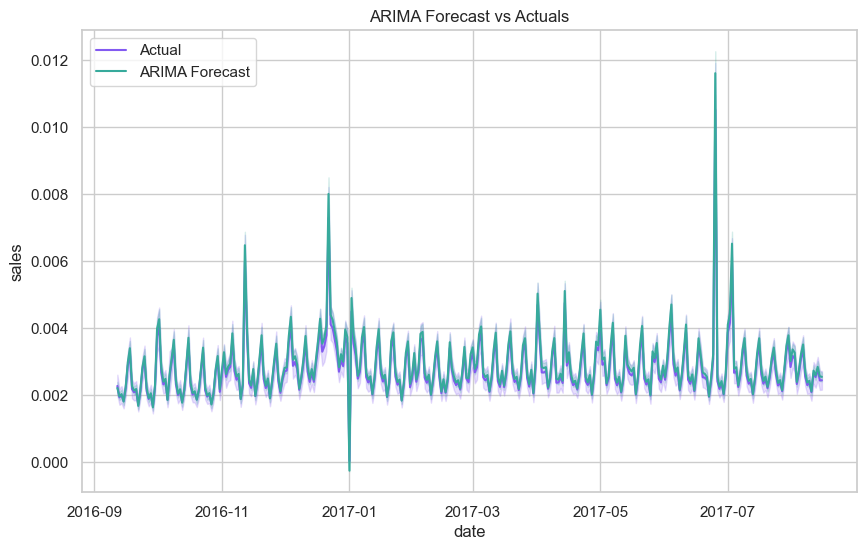

In [116]:
# Apply the function to plot the predictions vs actual
plot_predictions(test_data['date'],y_test, forecast_arima, 'ARIMA Forecast', 'ARIMA Forecast vs Actuals')

In [117]:
# Calcualte the metrics
arima_metrics = evaluate_forecast(y_test, forecast_arima)

# Print out
arima_metrics

{'MSE': 4.719899248379541e-05,
 'RMSE': 0.006870152289709116,
 'RMSLE': 0.008989737904720086}

### SARIMA MODEL

In [118]:
# Define the Model Instance
model_sarima = sm.tsa.SARIMAX(y_train, exog=X_train[ex_variables], order=(1,1,0), seasonal_order=(1,0,0,12))

# Fit the Model
results_sarima = model_sarima.fit(disp=False)

# Make Predictions
forecast_sarima = results_sarima.predict(start=len(train_data), end=len(train_data) + len(test_data) - 1, exog=X_test[ex_variables])

In [ ]:
# Apply the function to plot the predictions vs actual
plot_predictions(test_data['date'],y_test, forecast_sarima, 'SARIMA Forecast', 'SARIMA Forecast vs Actuals')

In [ ]:
# Calcualte the metrics
sarima_metrics = evaluate_forecast(y_test, forecast_sarima)

# Print out
sarima_metrics

### EXPONENTIAL SMOOTHING MODEL

In [ ]:
# Define Instance of the Exponential Smoothing model
model_ets = ExponentialSmoothing(y_train, seasonal='add', seasonal_periods=12)

# Fit the Model
results_ets = model_ets.fit()

# Make Initial Forecast
initial_forecast = results_ets.forecast(steps=len(y_test))

In [ ]:
# Use initial forecast obtained and exogenous Variables defined to predict y_test.
X_adjust_train = pd.concat([y_train.shift(-1).dropna().rename("forecast"), X_train[ex_variables].iloc[1:, :]], axis=1)
X_adjust_test = pd.concat([pd.Series(initial_forecast, index=y_test.index).rename("forecast"), X_test[ex_variables]], axis=1)

# Drop rows with missing values from both the adjusted train and test
X_adjust_train = X_adjust_train.dropna()
y_adjust_train = y_train.loc[X_adjust_train.index]

X_adjust_test = X_adjust_test.dropna()
y_adjust_test = y_test.loc[X_adjust_test.index]

# Convert feature names to strings
X_adjust_train.columns = X_adjust_train.columns.astype(str)
X_adjust_test.columns = X_adjust_test.columns.astype(str)

In [ ]:
# Define Linear Regression Model
lr = LinearRegression()

# Fit the model
lr.fit(X_adjust_train, y_adjust_train)

# Predict based on the X_adjusted_test
forecast_ets = lr.predict(X_adjust_test)

In [ ]:
# Apply the function to plot the predictions vs actual
plot_predictions(y_adjust_test.index,y_adjust_test, forecast_ets, 'Adjusted ETS Forecast', 'Adjusted ETS Forecast vs Actuals')

In [ ]:
# Calcualte the metrics
ets_metrics = evaluate_forecast(y_adjust_test, forecast_ets)

# Print out
ets_metrics

### XGBOOST REGRESSOR MODEL

In [ ]:
# Define XGBoost Regressor
model_xgb = xgb.XGBRegressor(objective ='reg:squarederror')

# Fit the Model
model_xgb.fit(X_train, y_train)

# Make Predictions
forecast_xgb = model_xgb.predict(X_test)

In [ ]:
# Apply the function to plot the predictions vs actual
plot_predictions(test_data['date'],y_test, forecast_xgb, 'XGBoost Forecast', 'XGBoost Forecast vs Actuals')

In [ ]:
# Create a Dictionary to combine all the results of the models
data = {
    'Model': ['ARIMA', 'SARIMA', 'ETS', 'XGBOOST'],
    'MSE': [arima_metrics['MSE'], sarima_metrics['MSE'], ets_metrics['MSE'], xgboost_metrics['MSE']],
    'RMSE': [arima_metrics['RMSE'], sarima_metrics['RMSE'], ets_metrics['RMSE'], xgboost_metrics['RMSE']],
    'RMSLE': [arima_metrics['RMSLE'], sarima_metrics['RMSLE'], ets_metrics['RMSLE'], xgboost_metrics['RMSLE']]
}

# Create a Performance df
performance_df = pd.DataFrame(data)

# Display
performance_df

1. **MSE (Mean Squared Error)**: MSE measures the average squared difference between the predicted values and the actual values. It is commonly used to evaluate regression models. A lower MSE indicates a better fit to the data.

2. **RMSE (Root Mean Squared Error)**: RMSE is the square root of the MSE. It provides a measure of the average magnitude of the errors in the same units as the target variable. Like MSE, lower RMSE values indicate better model performance.

3. **RMSLE (Root Mean Squared Logarithmic Error)**: RMSLE is a variation of RMSE that is often used when dealing with skewed or non-normally distributed target variables. It calculates the RMSE of the logarithm of the predicted and actual values. RMSLE is particularly useful when the target variable has a wide range, and the errors are expected to be proportional to the actual values. Lower RMSLE values indicate better performance, similar to RMSE.

Now, MAE (Mean Absolute Error) is greater than all of these metrics because MAE measures the average absolute difference between the predicted values and the actual values. It is less sensitive to outliers compared to MSE and RMSE. In some cases, MAE can be greater than MSE and RMSE because it does not penalize larger errors as significantly.

In [ ]:
# Plot the performance 
fig = px.bar(performance_df, x='Model', y='RMSLE', title='RMSLE by Model', height=600)
fig.update_xaxes(title='Model')
fig.update_yaxes(title='RMSLE')
fig.update_xaxes(categoryorder='total ascending')

# Add data labels on top of the bars
fig.update_traces(texttemplate='%{y}', textposition='outside')

# Show plot
fig.show()

# HYPERPARAMETER TUNING
In pursuit of further enhancing the performance of our XGBoost model, we will be conducting hyperparameter tuning. Specifically, we will utilize a randomized search approach. This process aims to fine-tune the model's hyperparameters, optimizing its predictive capabilities and potentially yielding even better results.

In [ ]:
# Params
xgb_param_dist = {
    'learning_rate': [0.01, 0.1, 0.3],
    'n_estimators': [50, 100, 200],
    'max_depth': [2, 4, 6]
}

# Model Instance
model_xgb = xgb.XGBRegressor(objective='reg:squarederror')

# Perform the search
random_search = RandomizedSearchCV(
    model_xgb,
    param_distributions=xgb_param_dist,
    n_iter=10,  # Number of iterations as needed
    cv=5,       # Number of cross-validation folds
    scoring='neg_mean_squared_error',
    random_state=42
)

# Fit the model
random_search.fit(X_train, y_train)

# Get the best params
best_xgb_params = random_search.best_params_

# Print out
print("Best XGBoost parameters:", best_xgb_params)

# Get best estimator
best_xgb_model = random_search.best_estimator_

# Print out
best_xgb_model

In [ ]:
# Prediction with the best model
forecast_xgb_best = best_xgb_model.predict(X_test)

### NB//
Please Do not continue runnibg the codes from here onwards

In [ ]:
# Merge oil_data and holi_eve_data based on 'date'
train_data = pd.merge(train_data, oil_data, on='date', how='left')
train_data = pd.merge(train_data, holi_eve_data, on='date', how='left')

# Merge stores_data based on 'store_nbr'
train_data = pd.merge(train_data, stores_data, on='store_nbr', how='left')

# Merge 'transc_data' based on 'date' and 'store_nbr'
train_data = pd.merge(train_data, transc_data, on=['date', 'store_nbr'], how='left')

In [ ]:
train_data.isna().sum()

In [ ]:
train_data.duplicated().sum()

### Data Cleaning
You further fill the missing values as a result of the merger

In [ ]:
# Sort the DataFrame by 'store_nbr' and 'date' to ensure proper filling
train_data = train_data.sort_values(by=['store_nbr', 'date'])

# Forward-fill NaN values in the 'city' column based on 'store_nbr'
train_data['city'] = train_data.groupby('store_nbr')['city'].fillna(method='ffill')

# Forward-fill NaN values in the 'state' column based on 'store_nbr'
train_data['state'] = train_data.groupby('store_nbr')['state'].fillna(method='ffill')

# Forward-fill NaN values in the 'state' column based on 'store_nbr'
train_data['locale'] = train_data.groupby('store_nbr')['locale'].fillna(method='ffill')

# Forward-fill NaN values in the 'state' column based on 'store_nbr'
train_data['locale_name'] = train_data.groupby('store_nbr')['locale_name'].fillna(method='ffill')

# Forward-fill NaN values in the 'state' column based on 'store_nbr'
train_data['description'] = train_data.groupby('store_nbr')['description'].fillna(method='ffill')

# Forward-fill NaN values in the 'state' column based on 'store_nbr'
train_data['transferred'] = train_data.groupby('store_nbr')['transferred'].fillna(method='ffill')

In [ ]:
# Filter and keep only rows where 'type' is not 'Holiday' or 'transferred' is False
train_data[~((train_data['Holiday Type'] == 'Holiday') & (train_data['transferred'] == True))]

# Update 'type' column: Change 'Transfer' to 'Holiday'
train_data.loc[train_data['Holiday Type'] == 'Transfer', 'Holiday Type'] = 'Holiday'

In [ ]:
# Replace NaN values in 'Holiday Type' column based on the day of the week
train_data['Holiday Type'].fillna(train_data['date'].apply(lambda x: 'Work Day' if x.weekday() < 5 else 'Weekend'), inplace=True)

In [ ]:
# Define the product category groups
groups = {
    'Grocery and Household Essentials': ['AUTOMOTIVE', 'BABY CARE', 'BEAUTY', 'BEVERAGES', 'BREAD/BAKERY', 'CLEANING', 'DAIRY', 'EGGS', 'GROCERY I', 'GROCERY II', 'HOME AND KITCHEN I', 'HOME AND KITCHEN II', 'HOME APPLIANCES', 'HOME CARE', 'PERSONAL CARE', 'PET SUPPLIES', 'SCHOOL AND OFFICE SUPPLIES'],
    'Apparel and Fashion': ['LADIESWEAR', 'LINGERIE'],
    'Entertainment and Leisure': ['BOOKS', 'CELEBRATION', 'MAGAZINES', 'PLAYERS AND ELECTRONICS'],
    'Hardware and Home Improvement': ['HARDWARE', 'LAWN AND GARDEN'],
    'Food and Beverages': ['DELI', 'FROZEN FOODS', 'LIQUOR,WINE,BEER', 'MEATS', 'PREPARED FOODS', 'PRODUCE', 'SEAFOOD']
}

# Create a new column 'Product_Category_Group' based on the mapping
train_data['Product_Category'] = train_data['Product'].apply(lambda x: next((group for group, categories in groups.items() if x in categories), 'Other'))

train_data.head()

In [ ]:
# Create a time series plot of 'sales' over time
plt.figure(figsize=(12, 6))
plt.plot(train_data['date'], train_data['sales'], label='Sales')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Sales Over Time')
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
# Create a bar plot of 'sales' by product category
plt.figure(figsize=(10, 6))
sns.barplot(x='Product_Category', y='sales', data=train_data)
plt.xlabel('Product Category')
plt.ylabel('Sales')
plt.title('Sales by Product Category')
plt.xticks(rotation=45)
plt.show()

In [ ]:
# Create a scatter plot of 'oil price' vs. 'sales'
plt.figure(figsize=(8, 6))
sns.scatterplot(x='oil price', y='sales', data=train_data)
plt.xlabel('Oil Price')
plt.ylabel('Sales')
plt.title('Sales vs. Oil Price')
plt.show()

In [ ]:
train_data.info()

In [ ]:
train_data.isna().sum()